In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('/content/drive/My Drive/open data/train.csv')
test = pd.read_csv('/content/drive/My Drive/open data/test_x.csv')

In [3]:
print(train.shape)
print(test.shape)

(45532, 78)
(11383, 77)


In [ ]:
# 결측치 -> X
pd.set_option('display.max_rows', 500)  # 중간 생략 없이 다 보여줭
train.isnull().sum()

In [ ]:
train.head()

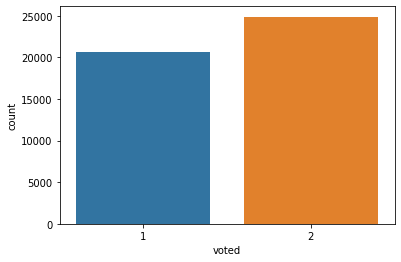

In [6]:
# unbalanced data? No
barchart=sns.countplot(x='voted',data=train);

In [ ]:
# 범주형 feature => Q_(a~t), age_group, education, engnat, familysize, gender, hand, married, race, religion, tp__(01~07), urban, wr(01~13), wf_(01~03)

# 연속형 feature => Q_E(a~t)

# 순서 존재 X 범주형 => gender, race, religion, engnat => 매핑 필요?
# 순서 존재하는  범주형 => education, urban, age_group => age group만 매핑하면될듯?

print(train.religion.value_counts())

In [ ]:
# 성별 매핑 (0,1)
gender_mapping = {'Female':0 , 'Male':1 }
train['gender'] = train['gender'].map(gender_mapping)
train.head()

In [ ]:
# 연령대 매핑 
age_mapping = {'10s':1, '20s':2, '30s':3, '40s':4, '50s':5, '60s':6, '+70s':7}
train['age_group'] = train['age_group'].map(age_mapping)
train.head()

In [ ]:
# race, religion, engnat => 얘네는 순서가 없는 명목형 범주 feature => 가변수 만들면 feature 너무 많을텐데 AutoK~
# engnat은 일단 냅둔다 치고 나머지 2개부터

#train2 = pd.get_dummies(data=train1, columns=['race'])
#train2 = pd.get_dummies(data=train2, columns=['religion'])

#train2.head() # 그냥 해봤는데 이건 아무리 봐도 아닌거 같다. (feature 96개)

In [9]:
# 인종 매핑 
race_mapping = {'White':1, 'Asian':2, 'Other':3, 'Black':4, 'Native American':5, 'Arab':6, 'Indigenous Australian':7}
train['race'] = train['race'].map(race_mapping)

# 종교 매핑
religion_mapping = {'Atheist':1, 'Agnostic':2, 'Christian_Catholic':3, 'Christian_Other':4, 'Christian_Protestant':5, 'Other':6, 'Hindu':7,
                    'Muslim':8, 'Buddhist':9, 'Jewish':10, 'Christian_Mormon':11, 'Sikh':12}
train['religion'] = train['religion'].map(religion_mapping)
train.head()

# 얘도 부작용 우려 => 수치를 부여해서 얘네 사이에 순서가 생겨버리면 AutoK....

,index,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,5.0,539,2.0,586,4.0,1095,5.0,1142,4.0,1287,4.0,883,4.0,851,2.0,851,5.0,816,2.0,579,2.0,924,2.0,366,2.0,876,2.0,633,1.0,1115,3,2,1,4,0,1,3,1,6,2,2,2,1,2,1,7,4,4,3,1,2,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,3.0,2190,1.0,826,1.0,4082,5.0,1867,3.0,1264,5.0,2943,4.0,3927,1.0,4329,5.0,1828,1.0,1214,5.0,2414,5.0,1356,1.0,3039,4.0,4304,1.0,1346,2,4,2,3,0,1,1,2,7,1,1,0,0,1,2,3,4,0,4,3,2,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1
2,2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,1.0,531,4.0,1167,1.0,1016,3.0,2653,2.0,1569,5.0,998,5.0,2547,2.0,918,4.0,2153,2.0,1304,1.0,1131,5.0,937,4.0,1327,1.0,1170,1.0,1409,3,3,1,3,1,1,2,1,6,2,3,1,5,3,4,2,6,1,3,2,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1
3,3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,2.0,1519,4.0,159,3.0,2275,5.0,2809,4.0,5614,3.0,3219,4.0,1296,4.0,9046,4.0,1216,4.0,1169,4.0,23868,3.0,581,4.0,8830,4.0,2392,5.0,1312,2,4,2,0,0,1,1,2,7,2,4,1,1,1,3,1,3,1,3,3,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1
4,4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,2.0,628,1.0,991,1.0,1259,5.0,1153,5.0,1388,5.0,740,5.0,1181,4.0,547,2.0,575,1.0,754,4.0,1140,5.0,323,5.0,1070,1.0,583,2.0,1889,2,3,1,2,1,1,2,1,2,1,1,1,6,0,2,0,6,2,6,1,1,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1


In [ ]:
# index 필요 없지 않나? => 제거

train = train.drop(['index'],axis=1)
train.head()

In [11]:
# X, y 나누기

estimators = ['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand', 'married',
       'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05', 'tp06',
       'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01', 'wf_02',
       'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07',
       'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']

X = train[estimators]
y = train['voted']

In [12]:
# 숫자형 / 범주형 구분

num = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE','QiE', 'QjE', 'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE']
X_num = X[num]
cat = [x for x in estimators if x not in num]
X_cat = X[cat] 

In [13]:
# X끼리 상관계수 높은 애들을 추려보자

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X, 20))

Top Absolute Correlations
age_group  married    0.642361
wr_02      wr_10      0.622419
QfA        QnA        0.586806
wr_07      wr_10      0.579492
wr_02      wr_07      0.542845
tp01       tp06       0.533509
tp04       tp09       0.499477
wr_10      wr_12      0.497165
QiA        QkA        0.494388
QkA        QnA        0.493859
wr_05      wr_07      0.488124
QoA        QtA        0.479779
wr_02      wr_12      0.479133
wr_05      wr_13      0.479021
wr_07      wr_12      0.474846
QiA        QnA        0.473264
QbA        QtA        0.469701
wr_04      wr_05      0.465709
wr_08      wr_10      0.465421
QjA        QtA        0.463567
dtype: float64


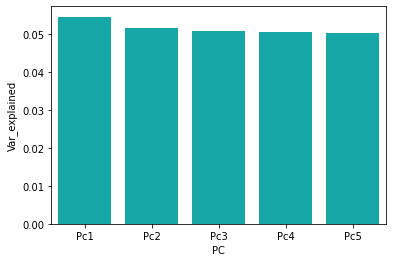

In [14]:
# 연속형 => PCA => Shit 결과가 개쓰레기다. (애초에 상관계수가 낮은 애들)
# X 전체 놓고 돌리면 그나마 낫지만 쓰레기 (설명력 10% 넘는 애가 없음)
# 범주형만 PCA => 제일 낫지만 그마저도 5번 그어야 30%설명

from sklearn.preprocessing import StandardScaler
X_num_st = StandardScaler().fit_transform(X_num)

from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
X_num_pca = pca.fit_transform(X_num_st)
X_num_pca = pd.DataFrame(data = X_num_pca, columns = ['Pc1', 'Pc2', 'Pc3', 'Pc4', 'Pc5'])
X_num_pca['vote'] = y
pca.explained_variance_ratio_

df = pd.DataFrame({'Var_explained':pca.explained_variance_ratio_, 'PC':['Pc1','Pc2','Pc3','Pc4','Pc5']})
sns.barplot(x='PC',y="Var_explained", data=df, color="c")

In [15]:
# 그럼에도 불구하고 쓸모없는 애들이 존재할 것이다. feature selection 해보자.
# 1) Feature selection using SelectFromModel and LassoCV
# 이건 아니다
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

clf = LassoCV().fit(X, y)
importance = np.abs(clf.coef_)
print(importance)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.92872338e-08
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.61631253e-09
 0.00000000e+00 1.89867218e-09 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.54579212e-09
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.71341702e-09
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.09719070e-10
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [29]:
# feature selection

x_var = np.var(X).sort_values(ascending=False)
X_lowvar = x_var[x_var<1]

In [ ]:
# 위에서 구한 분산 낮은 변수 제외

new_estimators = ['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'familysize',
       'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05', 'tp06',
       'tp07', 'tp08', 'tp09', 'tp10']

new_X = train[new_estimators]

In [38]:
# 분산 낮은애들 컷하고 남은 X끼리 상관계수 높은 애들을 추려보자

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(new_X, 20))

Top Absolute Correlations
QfA   QnA     0.586806
tp01  tp06    0.533509
tp04  tp09    0.499477
QiA   QkA     0.494388
QkA   QnA     0.493859
QoA   QtA     0.479779
QiA   QnA     0.473264
QbA   QtA     0.469701
QjA   QtA     0.463567
QkA   QtA     0.462664
QcA   QtA     0.459220
QoA   QsA     0.448600
QiA   QtA     0.443742
QcA   QjA     0.435447
QaA   QqA     0.428917
QnA   QrA     0.427314
QkA   QrA     0.423531
      QoA     0.421948
QpA   QtA     0.420123
QbA   QjA     0.416002
dtype: float64


In [49]:
new_estimators2 = ['QaA', 'QbA', 'QcA',
       'QfA', 'QiA', 'QjA',
       'QkA', 'QnA', 'QoA',
       'QpA', 'QqA', 'QrA', 'QsA', 'QtA',
       'tp01', 'tp04', 'tp06', 'tp09']
new_X2 = train[new_estimators2]
new_X2

,QaA,QbA,QcA,QfA,QiA,QjA,QkA,QnA,QoA,QpA,QqA,QrA,QsA,QtA,tp01,tp04,tp06,tp09
0,3.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0,2,1,1,4
1,5.0,5.0,3.0,3.0,5.0,3.0,5.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0,1,0,2,0
2,4.0,1.0,1.0,1.0,3.0,2.0,5.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0,2,5,4,1
3,3.0,3.0,4.0,2.0,5.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,5.0,2,1,3,1
4,1.0,1.0,5.0,2.0,5.0,5.0,5.0,2.0,1.0,4.0,5.0,5.0,1.0,2.0,1,6,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,2.0,5.0,4.0,1.0,1.0,4.0,4.0,1.0,2.0,4.0,2.0,1.0,5.0,4.0,1,1,6,6
45528,2.0,3.0,4.0,2.0,2.0,5.0,2.0,2.0,4.0,4.0,2.0,3.0,4.0,4.0,2,3,3,1
45529,4.0,1.0,1.0,4.0,5.0,1.0,5.0,4.0,1.0,1.0,5.0,5.0,3.0,1.0,4,4,1,1
45530,1.0,3.0,4.0,1.0,5.0,1.0,5.0,3.0,1.0,1.0,4.0,4.0,4.0,1.0,1,4,1,2


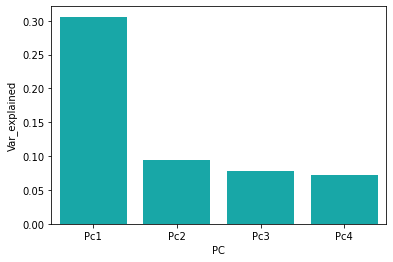

In [50]:
# 분산 낮은 변수 cut => 상관계수 높은 애들끼리 PCA

from sklearn.preprocessing import StandardScaler
new_X2_st = StandardScaler().fit_transform(new_X2)

from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
new_X2_pca = pca.fit_transform(new_X2_st)
new_X2_pca = pd.DataFrame(data = new_X2_pca, columns = ['Pc1', 'Pc2', 'Pc3', 'Pc4'])
new_X_pca['vote'] = y
pca.explained_variance_ratio_

df = pd.DataFrame({'Var_explained':pca.explained_variance_ratio_, 'PC':['Pc1','Pc2','Pc3','Pc4']})
sns.barplot(x='PC',y="Var_explained", data=df, color="c")

In [ ]:
new_X2_pca = new_X2_pca.drop(['Pc4'],axis=1)


In [59]:
n_feat = [x for x in new_estimators if x not in new_estimators2]
X2 = X[n_feat];X2
X_with_pca = pd.concat([new_X2_pca, X2], axis=1);X_with_pca 

,Pc1,Pc2,Pc3,QaE,QbE,QcE,QdA,QdE,QeA,QeE,QfE,QgA,QgE,QhA,QhE,QiE,QjE,QkE,QlA,QlE,QmA,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE,age_group,familysize,race,religion,tp02,tp03,tp05,tp07,tp08,tp10
0,1.863299,1.524465,0.851076,363,1370,997,1.0,1024,2.0,1577,539,2.0,586,4.0,1095,1142,1287,883,4.0,851,2.0,851,816,579,924,366,876,633,1115,3,4,1,6,2,2,2,7,4,3
1,2.297780,-0.151168,0.508993,647,1313,3387,5.0,2969,1.0,4320,2190,1.0,826,1.0,4082,1867,1264,2943,4.0,3927,1.0,4329,1828,1214,2414,1356,3039,4304,1346,2,3,2,7,1,0,1,3,4,4
2,3.834616,-1.745946,-0.564070,1623,1480,1021,4.0,3374,5.0,1333,531,4.0,1167,1.0,1016,2653,1569,998,5.0,2547,2.0,918,2153,1304,1131,937,1327,1170,1409,3,3,1,6,3,1,3,2,6,3
3,-0.061589,0.140854,0.780189,504,2311,992,3.0,3245,1.0,357,1519,4.0,159,3.0,2275,2809,5614,3219,4.0,1296,4.0,9046,1216,1169,23868,581,8830,2392,1312,2,0,2,7,4,1,1,1,3,3
4,1.773052,-0.702311,-0.577180,927,707,556,2.0,1062,1.0,1014,628,1.0,991,1.0,1259,1153,1388,740,5.0,1181,4.0,547,575,754,1140,323,1070,583,1889,2,2,1,2,1,1,0,0,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,-2.157605,-0.367340,2.865563,1050,619,328,1.0,285,1.0,602,267,1.0,315,1.0,483,1016,278,611,5.0,215,4.0,388,299,1915,439,823,309,586,2252,1,1,1,10,2,6,2,3,0,4
45528,-1.806052,-0.640040,0.173068,581,1353,1164,1.0,798,3.0,1680,560,2.0,640,1.0,1415,4494,1392,2478,5.0,1268,3.0,843,1401,1524,719,754,1118,654,1197,3,2,1,1,2,2,1,3,4,5
45529,4.890924,-0.044020,-1.286391,593,857,1047,4.0,1515,5.0,1690,1253,5.0,1094,1.0,1283,2209,1764,1062,5.0,1489,1.0,1908,891,1298,1200,473,1779,1355,667,1,1,1,4,4,2,0,0,2,6
45530,2.222095,-0.642427,-0.522623,747,1331,892,2.0,1281,1.0,1328,599,1.0,650,1.0,1429,1748,770,1025,5.0,742,4.0,4180,707,489,913,1301,1680,737,1124,4,2,1,1,2,0,0,3,2,4


## 모델링 (나중에 분리해서 모델링만 따로 올리겠음)

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_with_pca,y,test_size=0.3,random_state=10)       # 국룰이라는 7:3으로 train:test
#모델링
def modeling(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    metrics(y_test,pred)
#평가 지표
def metrics(y_test,pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_score = roc_auc_score(y_test,pred,average='macro')
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1,roc_score,recall))

In [66]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
modeling(lgb,X_train,X_test,y_train,y_test)
y_pred = lgb.predict(X_test)

정확도 : 0.69, 정밀도 : 0.63, 재현율 : 0.75
f1-score : 0.69, auc : 0.69


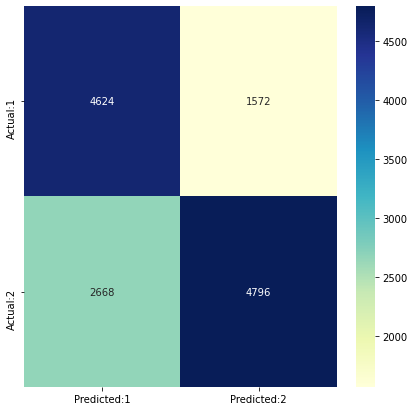

In [67]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2'],index=['Actual:1','Actual:2'])
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [78]:
# catboost

from catboost import CatBoostClassifier, Pool

catboost = CatBoostClassifier(iterations=10)
modeling(catboost,X_train,X_test,y_train,y_test)
y_pred = catboost.predict(X_test)

Learning rate set to 0.5
0:	learn: 0.6176898	total: 25.5ms	remaining: 229ms
1:	learn: 0.5992282	total: 48ms	remaining: 192ms
2:	learn: 0.5923794	total: 73ms	remaining: 170ms
3:	learn: 0.5888741	total: 99.4ms	remaining: 149ms
4:	learn: 0.5870096	total: 126ms	remaining: 126ms
5:	learn: 0.5855310	total: 151ms	remaining: 101ms
6:	learn: 0.5842722	total: 177ms	remaining: 76ms
7:	learn: 0.5831404	total: 205ms	remaining: 51.3ms
8:	learn: 0.5820323	total: 229ms	remaining: 25.4ms
9:	learn: 0.5808533	total: 260ms	remaining: 0us
정확도 : 0.68, 정밀도 : 0.62, 재현율 : 0.75
f1-score : 0.68, auc : 0.69


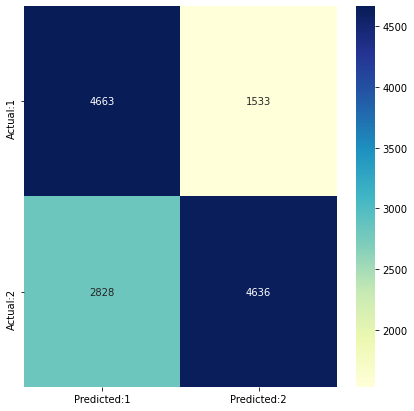

In [79]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2'],index=['Actual:1','Actual:2'])
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [80]:
# XGBOOST

import xgboost as xgb
xgbcl = xgb.XGBClassifier()
modeling(xgbcl,X_train,X_test,y_train,y_test)
y_pred = xgbcl.predict(X_test)

정확도 : 0.69, 정밀도 : 0.63, 재현율 : 0.76
f1-score : 0.69, auc : 0.69


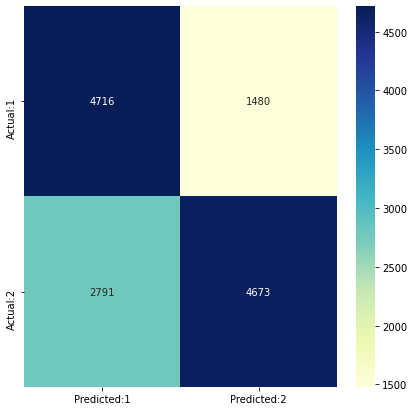

In [81]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2'],index=['Actual:1','Actual:2'])
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");